In [411]:
import numpy as np

In [569]:
r, c = 100, 10
w = 5

X = np.arange(r * c).reshape(r, c)
X.shape

(100, 10)

In [263]:
X[:5]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]])

**[1]** One time serie

In [264]:
indices = np.arange(c)
indices

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Repeat w times

In [265]:
np.repeat(indices, w)

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9,
       9, 9, 9, 9])

Reshape so that number of columns is equal to w (window size).

In [266]:
np.repeat(indices, w).reshape(-1, w)

array([[0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6, 6, 6],
       [7, 7, 7, 7, 7, 7, 7],
       [8, 8, 8, 8, 8, 8, 8],
       [9, 9, 9, 9, 9, 9, 9]])

Sum 1 to each row

In [267]:
np.repeat(indices, w).reshape(-1, w) + np.arange(w)

array([[ 0,  1,  2,  3,  4,  5,  6],
       [ 1,  2,  3,  4,  5,  6,  7],
       [ 2,  3,  4,  5,  6,  7,  8],
       [ 3,  4,  5,  6,  7,  8,  9],
       [ 4,  5,  6,  7,  8,  9, 10],
       [ 5,  6,  7,  8,  9, 10, 11],
       [ 6,  7,  8,  9, 10, 11, 12],
       [ 7,  8,  9, 10, 11, 12, 13],
       [ 8,  9, 10, 11, 12, 13, 14],
       [ 9, 10, 11, 12, 13, 14, 15]])

Notice that we are only interested in indices **lower than window size - 1**, in other words, repeat base indices **n - window size**

Redo from **[1]**, but repeat only **n - window size** times

In [268]:
# All in one cell
number_ts_splits = c - w + 1
print("Number of new time serie splits (also rows):", number_ts_splits)

indices = np.arange(number_ts_splits)
np.repeat(indices, w).reshape(-1, w) + np.arange(w)

Number of new time serie splits (also rows): 4


array([[0, 1, 2, 3, 4, 5, 6],
       [1, 2, 3, 4, 5, 6, 7],
       [2, 3, 4, 5, 6, 7, 8],
       [3, 4, 5, 6, 7, 8, 9]])

Array of time series. Now we test a dataset of time series with two examples, WLOG.

In [299]:
np.arange(number_ts_splits)

array([0, 1, 2, 3])

In [316]:
# All in one cell
number_ts_splits = c - w + 1
print("Number of new time serie splits (also rows):", number_ts_splits)

r_test = 2
indices = np.arange(number_ts_splits)
ts_indices_window = np.repeat(indices, w).reshape(-1, w) + np.arange(w)
dataset_window = np.stack([ts_indices_window] * r_test, axis=0)
dataset_window.shape, dataset_window

Number of new time serie splits (also rows): 4


((2, 4, 7),
 array([[[0, 1, 2, 3, 4, 5, 6],
         [1, 2, 3, 4, 5, 6, 7],
         [2, 3, 4, 5, 6, 7, 8],
         [3, 4, 5, 6, 7, 8, 9]],
 
        [[0, 1, 2, 3, 4, 5, 6],
         [1, 2, 3, 4, 5, 6, 7],
         [2, 3, 4, 5, 6, 7, 8],
         [3, 4, 5, 6, 7, 8, 9]]]))

In [336]:
 i = np.array([[0, 1, 2, 3, 4, 5, 6],
                [1, 2, 3, 4, 5, 6, 7],
                [2, 3, 4, 5, 6, 7, 8],
                [3, 4, 5, 6, 7, 8, 9]])
    
x = np.random.randn(15, 10)
x.shape, i.shape, x[:,i].shape

((15, 10), (4, 7), (15, 4, 7))

In [681]:
class TSWindow():
    def __init__(self, window, pad=0, n_end_targets=0, skip_targets=False):
        self.window_data = window
        self.window = window + n_end_targets
        self.pad = pad
        self.number_ts_splits = None
        self.n_end_targets = n_end_targets
    def _window_dataset(self, X):
        r, f, c = X.shape
        self.number_ts_splits = c - self.window + 1
        base_indices = np.arange(self.number_ts_splits)
        w_displacement = np.arange(self.window)
        ts_indices_window = np.repeat(base_indices, self.window).reshape(-1, self.window) + w_displacement
    
        return X[..., ts_indices_window].reshape(-1, f, self.window)
    def extract_sets(self, X):
        """ Desc: 
            Input:
                - self. General object
                - X, numpy array (row, col), array of time series
            Output:
                - data , numpy array, array of data without target
                - target, numpy array, array of target values
        """
        if self.n_end_targets == 0:
            raise Exception("Target setup error: No target points assigned")
        X_window = self._window_dataset(X)
        return X_window[..., :self.window_data], X_window[..., -self.n_end_targets:]

In [ ]:
class TSWindow():
    def __init__(self, window, pad=0, n_end_targets=0, skip_targets=False):
        self.window_data = window
        self.window = window + n_end_targets
        self.pad = pad
        self.number_ts_splits = None
        self.n_end_targets = n_end_targets
    def _window_dataset(self, X):
        r, f, c = X.shape
        self.number_ts_splits = c - self.window + 1
        base_indices = np.arange(self.number_ts_splits)
        w_displacement = np.arange(self.window)
        ts_indices_window = np.repeat(base_indices, self.window).reshape(-1, self.window) + w_displacement
    
        return X[..., ts_indices_window].reshape(-1, f, self.window)
    def extract_sets(self, X):
        """ Desc: 
            Input:
                - self. General object
                - X, numpy array (row, col), array of time series
            Output:
                - data , numpy array, array of data without target
                - target, numpy array, array of target values
        """
        if self.n_end_targets == 0:
            raise Exception("Target setup error: No target points assigned")
        X_window = self._window_dataset(X)
        return X_window[..., :self.window_data], X_window[..., -self.n_end_targets:]

Test instance with window of 5 elements and 2 target points

In [743]:
w = 5
n_end_targets=2
ts_windower = TSWindow(w, n_end_targets=n_end_targets)

## Test 1
Test with sequence of integer values for convinience

In [797]:
r, f, c = 10, 2, 10
w = 5

X = np.arange(r * f * c).reshape(r, f, c)
X.shape

(10, 2, 10)

In [745]:
X_window = ts_windower._window_dataset(X)
X_window.shape, X_window[:20]

((40, 3, 7),
 array([[[  0,   1,   2,   3,   4,   5,   6],
         [  1,   2,   3,   4,   5,   6,   7],
         [  2,   3,   4,   5,   6,   7,   8]],
 
        [[  3,   4,   5,   6,   7,   8,   9],
         [ 10,  11,  12,  13,  14,  15,  16],
         [ 11,  12,  13,  14,  15,  16,  17]],
 
        [[ 12,  13,  14,  15,  16,  17,  18],
         [ 13,  14,  15,  16,  17,  18,  19],
         [ 20,  21,  22,  23,  24,  25,  26]],
 
        [[ 21,  22,  23,  24,  25,  26,  27],
         [ 22,  23,  24,  25,  26,  27,  28],
         [ 23,  24,  25,  26,  27,  28,  29]],
 
        [[ 30,  31,  32,  33,  34,  35,  36],
         [ 31,  32,  33,  34,  35,  36,  37],
         [ 32,  33,  34,  35,  36,  37,  38]],
 
        [[ 33,  34,  35,  36,  37,  38,  39],
         [ 40,  41,  42,  43,  44,  45,  46],
         [ 41,  42,  43,  44,  45,  46,  47]],
 
        [[ 42,  43,  44,  45,  46,  47,  48],
         [ 43,  44,  45,  46,  47,  48,  49],
         [ 50,  51,  52,  53,  54,  55,  56]],
 


### Extract data and target

In [746]:
ts_windower.number_ts_splits

4

In [747]:
X_data, target = ts_windower.extract_sets(X)
X.shape, X_data.shape, target.shape

((10, 3, 10), (40, 3, 5), (40, 3, 2))

In [748]:
n = 5
X[:n], X_data[:n], target[:n]

(array([[[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
         [ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19],
         [ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29]],
 
        [[ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39],
         [ 40,  41,  42,  43,  44,  45,  46,  47,  48,  49],
         [ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59]],
 
        [[ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69],
         [ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79],
         [ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89]],
 
        [[ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99],
         [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
         [110, 111, 112, 113, 114, 115, 116, 117, 118, 119]],
 
        [[120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
         [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
         [140, 141, 142, 143, 144, 145, 146, 147, 148, 149]]]),
 array([[[ 0,  1,  2,  3,  4],
         [ 1,  2,  3,  4,  5],
        

## Test 2
Test with random values for convinience

In [816]:
f = 1
X_randn = np.random.randn(r, f, c)

w = 3
n_end_targets=2
ts_windower = TSWindow(w, n_end_targets=n_end_targets)

X_window = ts_windower._window_dataset(X_randn)
X_randn.shape, X_window.shape

((10, 1, 10), (60, 1, 5))

In [817]:
X_randn[:2], X_window[:2]

(array([[[ 1.8937752 , -0.73535811, -1.17115881,  0.32857728,
           0.31779131,  1.25287965, -1.15746567,  0.32952221,
           0.04581648, -1.24098518]],
 
        [[ 1.30895881, -0.23723923, -0.96298451, -1.39956914,
          -0.44570796, -0.05786424, -0.85048872, -0.69938559,
           1.03446585,  0.2769285 ]]]),
 array([[[ 1.8937752 , -0.73535811, -1.17115881,  0.32857728,
           0.31779131]],
 
        [[-0.73535811, -1.17115881,  0.32857728,  0.31779131,
           1.25287965]]]))

### Extract data and target

In [818]:
X_data, target = ts_windower.extract_sets(X_randn)
X_randn.shape, X_data.shape, target.shape

((10, 1, 10), (60, 1, 3), (60, 1, 2))

In [851]:
n = 5
X_randn[:n,0,:], X_data[:n,0,:], target[0]

(array([[ 1.8937752 , -0.73535811, -1.17115881,  0.32857728,  0.31779131,
          1.25287965, -1.15746567,  0.32952221,  0.04581648, -1.24098518],
        [ 1.30895881, -0.23723923, -0.96298451, -1.39956914, -0.44570796,
         -0.05786424, -0.85048872, -0.69938559,  1.03446585,  0.2769285 ],
        [ 1.49460325,  0.97105422,  0.10253515,  0.69845078, -1.10511549,
         -0.39967834, -0.12024263,  0.97656067,  0.14840541, -2.11214588],
        [-0.7515058 , -0.43369278,  0.55075105,  1.11949686, -1.53875578,
          0.31089321,  0.19598478, -0.14282068,  0.01871109,  1.21893912],
        [-1.90968072,  0.06191024, -1.02637263, -0.82379031,  1.13276629,
          0.29584838,  1.25145064,  0.27469117, -1.65180326,  0.51181712]]),
 array([[ 1.8937752 , -0.73535811, -1.17115881],
        [-0.73535811, -1.17115881,  0.32857728],
        [-1.17115881,  0.32857728,  0.31779131],
        [ 0.32857728,  0.31779131,  1.25287965],
        [ 0.31779131,  1.25287965, -1.15746567]]),
 array

## Visualizatiom

Visualize the full time series and each one of its splits.

In [852]:
from matplotlib import pyplot as plt

In [853]:
X_data.reshape(r, ts_windower.number_ts_splits, f, w).shape

(10, 6, 1, 3)

In [854]:
target.reshape(r, ts_windower.number_ts_splits, f, n_end_targets).shape

(10, 6, 1, 2)

[0 1 2] [1.49460325 0.97105422 0.10253515] | [3 4] [ 0.69845078 -1.10511549]
[1 2 3] [0.97105422 0.10253515 0.69845078] | [4 5] [-1.10511549 -0.39967834]
[2 3 4] [ 0.10253515  0.69845078 -1.10511549] | [5 6] [-0.39967834 -0.12024263]
[3 4 5] [ 0.69845078 -1.10511549 -0.39967834] | [6 7] [-0.12024263  0.97656067]
[4 5 6] [-1.10511549 -0.39967834 -0.12024263] | [7 8] [0.97656067 0.14840541]
[5 6 7] [-0.39967834 -0.12024263  0.97656067] | [8 9] [ 0.14840541 -2.11214588]


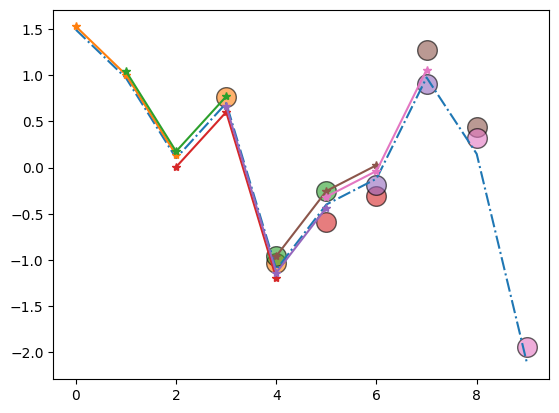

In [954]:
n_serie = 2
plt.plot(X_randn[n_serie, 0,:], linestyle="-.")

Y_temp = X_data.reshape(r, ts_windower.number_ts_splits, f, w)
target_temp = target.reshape(r, ts_windower.number_ts_splits, f, n_end_targets)

linestyle_data = "-"

s = 200
alpha = 0.6
target_marker = "o"

for i, y in enumerate(Y_temp[n_serie, :, 0, :]):
    noise = np.random.randn(1).item()
    n_points = len(y)
    x = np.arange(n_points) + i
    
    target_points = target_temp[n_serie, i, 0, :]
    x_target = np.arange(len(target_points)) + i + w
    
    print(x, y, "|", x_target, target_points)
    
    ax = plt.plot(x, y + 0.1 * noise, 
                  marker="*", 
                  linestyle=linestyle_data)
    color = ax[0].get_color()
    
    plt.scatter(x_target, target_points + 0.2 * noise, 
                marker=target_marker, 
                alpha=alpha, 
                s=s, 
                facecolor=color, 
                edgecolor="black")